In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import feather
import pickle
import re

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

In [3]:
pd.options.display.max_columns = 60
pd.options.display.max_rows = 60

In [4]:
train_df = feather.read_dataframe('data/encode_grp_train.feather')

In [5]:
train_df.columns = [re.sub(r'[^\x00-\x7f]',r'', column) for column in train_df.columns]

In [6]:
test_df = feather.read_dataframe('data/encode_grp_test.feather')

In [7]:
test_df.columns = [re.sub(r'[^\x00-\x7f]',r'', column) for column in test_df.columns]

In [8]:
train_df = train_df.sort_values('date_min', ascending = True).reset_index(drop = True)

In [9]:
split_index = int(len(train_df)*(1-len(test_df)/len(train_df)))

In [10]:
train_set = train_df[:split_index]
valid_set = train_df[split_index:]

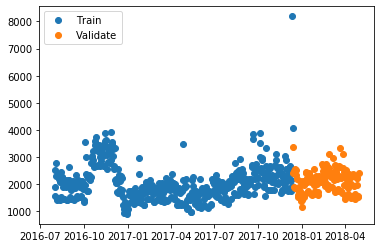

In [11]:
plt.plot_date(train_set['date_min'].value_counts().index, train_set['date_min'].value_counts().values)
plt.plot_date(valid_set['date_min'].value_counts().index, valid_set['date_min'].value_counts().values)
plt.legend(['Train', 'Validate']);

In [12]:
train_sample = train_set.sample(frac = 0.1, random_state = 2)
valid_sample = valid_set.sample(frac = 0.1, random_state = 2)

train_sample_ids = train_sample['fullVisitorId']
x_train_sample = train_sample.drop(['fullVisitorId', 'date_min', 'date_max','totals.transactionRevenue'], axis = 1 )
y_train_sample = train_sample['totals.transactionRevenue'].values

valid_sample_ids = valid_sample['fullVisitorId']
x_valid_sample = valid_sample.drop(['fullVisitorId', 'date_min', 'date_max','totals.transactionRevenue'], axis = 1 )
y_valid_sample = valid_sample['totals.transactionRevenue'].values

train_ids = train_set['fullVisitorId']
x_train = train_set.drop(['fullVisitorId', 'date_min', 'date_max','totals.transactionRevenue'], axis = 1 )
y_train = train_set['totals.transactionRevenue'].values

valid_ids = valid_set['fullVisitorId']
x_valid = valid_set.drop(['fullVisitorId', 'date_min', 'date_max','totals.transactionRevenue'], axis = 1 )
y_valid = valid_set['totals.transactionRevenue'].values

test_ids = test_df['fullVisitorId']
x_test = test_df.drop(['fullVisitorId', 'date_min', 'date_max','totals.transactionRevenue'], axis = 1 )
y_test = test_df['totals.transactionRevenue'].values

In [14]:
def rmse(x,y): return np.sqrt(mean_squared_error(x, y))
def print_score(m):
    train_pred_df = pd.DataFrame({'fullVisitorId': train_ids, 'PredictedRevenue' :m.predict(x_train), 'ActualRevenue':train_set['totals.transactionRevenue'] })
    val_pred_df = pd.DataFrame({'fullVisitorId': valid_ids, 'PredictedRevenue' :m.predict(x_valid), 'ActualRevenue':valid_set['totals.transactionRevenue']})
    
    res = [rmse(train_pred_df['PredictedRevenue'], train_pred_df['ActualRevenue']),rmse(val_pred_df['PredictedRevenue'], val_pred_df['ActualRevenue']),
          m.score(x_train, y_train), m.score(x_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [133]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
        params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

In [134]:
%time pred_test_y, model, pred_val_y = run_lgb(x_train, y_train, x_valid, y_valid, x_test)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.310912
[200]	valid_0's rmse: 0.303377
[300]	valid_0's rmse: 0.297731
[400]	valid_0's rmse: 0.295822
[500]	valid_0's rmse: 0.29528
[600]	valid_0's rmse: 0.293317
[700]	valid_0's rmse: 0.292524
[800]	valid_0's rmse: 0.291119
[900]	valid_0's rmse: 0.291564
Early stopping, best iteration is:
[816]	valid_0's rmse: 0.290813
Wall time: 1min 19s


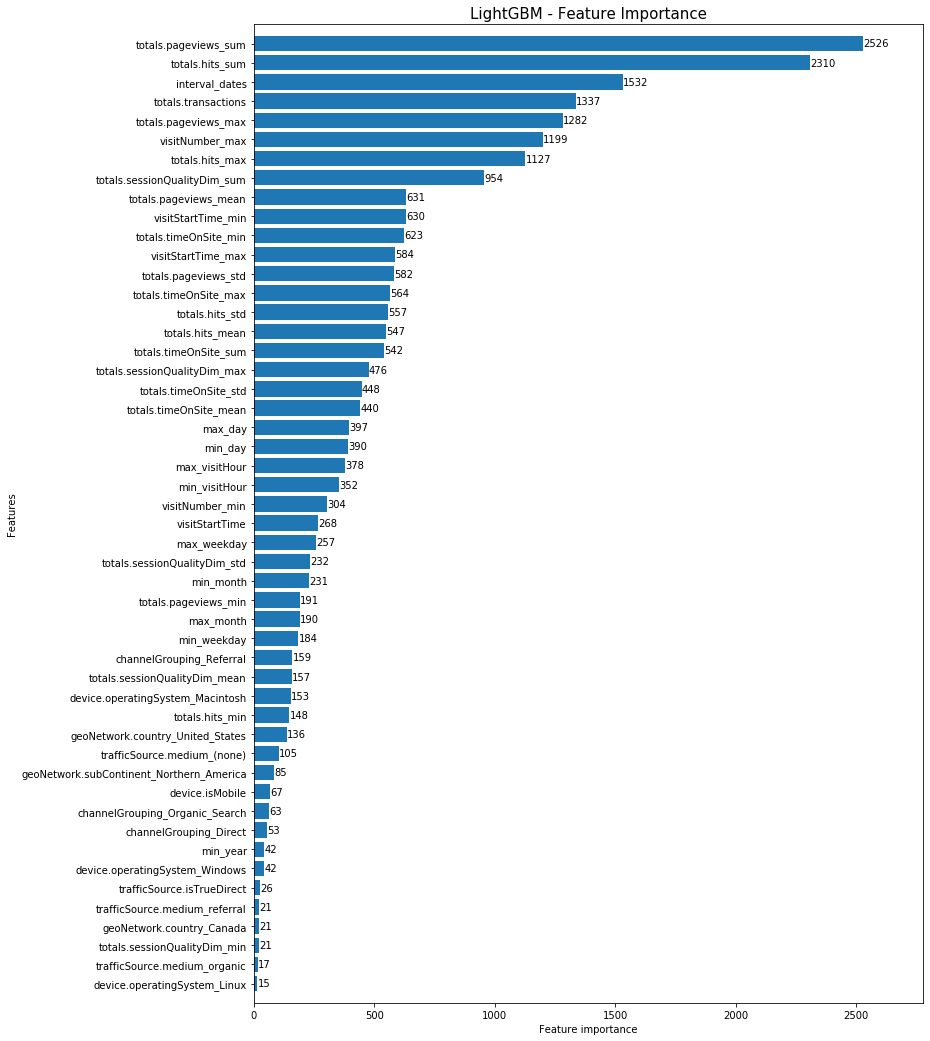

In [119]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [121]:
test_pred_df = pd.DataFrame({'fullVisitorId': test_ids, 'PredictedRevenue' :pred_test_y, 'ActualRevenue':y_test })

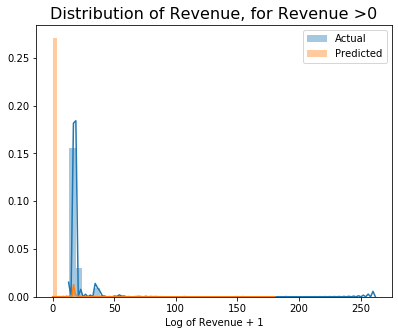

In [125]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.distplot(test_pred_df[test_pred_df['ActualRevenue'] > 0]["ActualRevenue"],hist = True, bins = 50)
ax = sns.distplot(test_pred_df[test_pred_df['PredictedRevenue'] > 0]["PredictedRevenue"],hist = True, bins = 50)
plt.legend(['Actual', 'Predicted'])
ax.set_xlabel('Log of Revenue + 1')
ax.set_title('Distribution of Revenue, for Revenue >0', fontsize = 16);

In [126]:
test_pred_df['ActualRevenue'].sum()

81691.62616929492

In [128]:
test_pred_df['PredictedRevenue'].sum()

110688.46941788124

In [136]:
submission = test_pred_df[['fullVisitorId', 'PredictedRevenue']]
submission.columns = ['fullVisitorId', 'PredictedLogRevenue']

In [138]:
submission.to_csv('data/submission_grp.csv', index = False)

In [15]:
m = RandomForestRegressor(oob_score=True)
m.fit(x_train_sample, y_train_sample)
print_score(m)

[0.832706569934022, 0.3602325104716026, 0.9132933825788959, 0.9635807054016456, 0.710648136683817]


In [16]:
preds = np.stack([t.predict(x_valid) for t in m.estimators_])

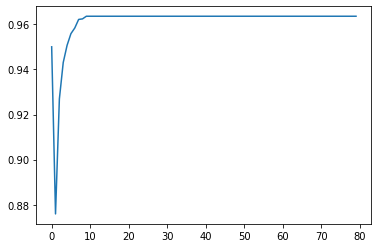

In [17]:
plt.plot([r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(80)]);

In [18]:
m = RandomForestRegressor(n_estimators = 20, oob_score=True)
m.fit(x_train_sample, y_train_sample)
print_score(m)

[0.9224406233466245, 0.36066273425091316, 0.8935991486872001, 0.9634936627140616, 0.6719425145396543]


In [19]:
m = RandomForestRegressor(n_estimators = 40, oob_score=True)
m.fit(x_train_sample, y_train_sample)
print_score(m)

[0.742389929148065, 0.353815759910035, 0.9310820413323687, 0.9648666091110237, 0.7464353661374472]


In [25]:
m = RandomForestRegressor(n_estimators = 40, min_samples_leaf = 3,  oob_score=True)
m.fit(x_train_sample, y_train_sample)
print_score(m)

[0.9074177704066597, 0.35827986526305816, 0.897036612698644, 0.9639744578917133, 0.753159015894029]


In [26]:
m = RandomForestRegressor(n_estimators = 40, min_samples_leaf = 30,  oob_score=True)
m.fit(x_train_sample, y_train_sample)
print_score(m)

[1.1159437993725487, 0.4084702373947287, 0.8442769474290779, 0.9531740544431259, 0.6906278834935032]


In [27]:
m = RandomForestRegressor(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5,  oob_score=True)
m.fit(x_train_sample, y_train_sample)
print_score(m)

[0.8672819126938377, 0.34811073426475786, 0.9059434943494177, 0.9659904762072928, 0.7165869416625958]


In [28]:
m = RandomForestRegressor(n_estimators = 10, min_samples_leaf = 3, max_features = 0.8,  oob_score=True)
m.fit(x_train_sample, y_train_sample)
print_score(m)

[0.862278686924306, 0.4362970924333125, 0.9070255613322532, 0.9465767434685105, 0.6946703027085134]


In [30]:
m = RandomForestRegressor(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5,min_samples_split = 100,  oob_score=True)
m.fit(x_train_sample, y_train_sample)
print_score(m)

[1.0527488913257341, 0.436887742593262, 0.8614144827763726, 0.9464319989150686, 0.690637172302077]


In [31]:
m = RandomForestRegressor(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5,max_leaf_nodes = 100,  oob_score=True)
m.fit(x_train_sample, y_train_sample)
print_score(m)

[0.8754311681184491, 0.34316366729525727, 0.9041676206196184, 0.9669502391662113, 0.7374259957149716]


In [32]:
m = RandomForestRegressor(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5,max_leaf_nodes = 1000,  oob_score=True)
m.fit(x_train_sample, y_train_sample)
print_score(m)

[0.8609389372503177, 0.3397324984995628, 0.9073142515375283, 0.9676078401863462, 0.7542843892778472]


In [33]:
m = RandomForestRegressor(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5,max_leaf_nodes = 10000,  oob_score=True)
m.fit(x_train_sample, y_train_sample)
print_score(m)

[0.8862631979798171, 0.3518855667861539, 0.9017814105413922, 0.9652488942525189, 0.7161752729580543]


In [34]:
m = RandomForestRegressor(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5,max_leaf_nodes = 1000,  oob_score=True)
m.fit(x_train, y_train)
print_score(m)

[0.38263942539329965, 0.27056951424904113, 0.981691713794449, 0.9794541816438548, 0.9481835136598016]


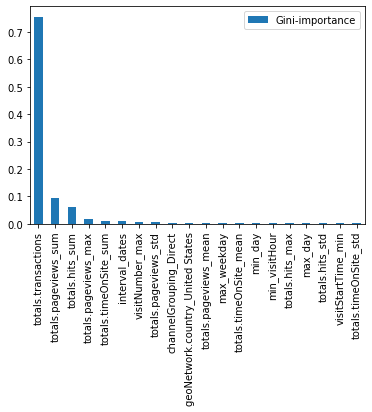

In [35]:
num_feats = 20
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x_train.columns, m.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending = False)[:num_feats].plot(kind='bar');

In [36]:
to_keep = importances.sort_values(by='Gini-importance', ascending = False)[:num_feats].index.tolist() + ['totals.transactionRevenue']

In [49]:
train_imp = train_set[to_keep]
train_ids_imp = train_set['fullVisitorId']

valid_imp = valid_set[to_keep]
valid_ids_imp = valid_set['fullVisitorId']

x_train_imp = train_imp.drop(['totals.transactionRevenue'], axis = 1 )
y_train_imp = train_imp['totals.transactionRevenue'].values

x_valid_imp = valid_imp.drop(['totals.transactionRevenue'], axis = 1 )
y_valid_imp = valid_imp['totals.transactionRevenue'].values


test_imp= test_df[to_keep]
test_ids_imp = test_df['fullVisitorId']
x_test_imp = test_imp.drop(['totals.transactionRevenue'], axis = 1 )
y_test_imp = test_imp['totals.transactionRevenue'].values

In [51]:
m = RandomForestRegressor(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5,max_leaf_nodes = 1000,  oob_score=True)
m.fit(x_train_imp, y_train_imp)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.5, max_leaf_nodes=1000,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40,
                      n_jobs=None, oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [53]:
test_pred_df = pd.DataFrame({'fullVisitorId': test_ids_imp, 'PredictedRevenue' :m.predict(x_test_imp), 'ActualRevenue':y_test_imp })

In [54]:
rmse(test_pred_df['PredictedRevenue'], test_pred_df['ActualRevenue'])

1.3903957582687758

In [55]:
test_pred_df[['PredictedRevenue', 'ActualRevenue']].sum()

PredictedRevenue    109959.727735
ActualRevenue        81691.626169
dtype: float64

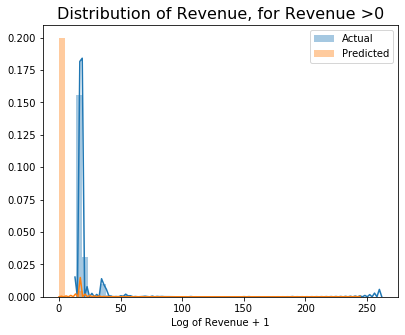

In [56]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.distplot(test_pred_df[test_pred_df['ActualRevenue'] > 0]["ActualRevenue"],hist = True, bins = 50)
ax = sns.distplot(test_pred_df[test_pred_df['PredictedRevenue'] > 0]["PredictedRevenue"],hist = True, bins = 50)
plt.legend(['Actual', 'Predicted'])
ax.set_xlabel('Log of Revenue + 1')
ax.set_title('Distribution of Revenue, for Revenue >0', fontsize = 16);